# Inference Tasks on Stellar Parameters to Stellar Parameters

In [1]:
import h5py
import torch
import matplotlib
import numpy as np
import pylab as plt
from astroNN.shared.matplotlib import pylab_style
from astroNN.gaia import fakemag_to_logsol
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from stellarperceptron.model import StellarPerceptron

from utils.plotting_utils import top_cbar
from utils.empirical_utils import estimate_teff_from_logg_rgb

pylab_style(paper=True)

# ================== hardware-related settings ==================
device = "cuda:1"  #"cpu" for CPU or "cuda:x" for a NVIDIA GPU
mixed_precision = True
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False
# ================== hardware-related settings ==================

nn_model = StellarPerceptron.load("./model_torch/", mixed_precision=mixed_precision, device=device)

f_train = h5py.File("./data_files/training_set.h5", "r")


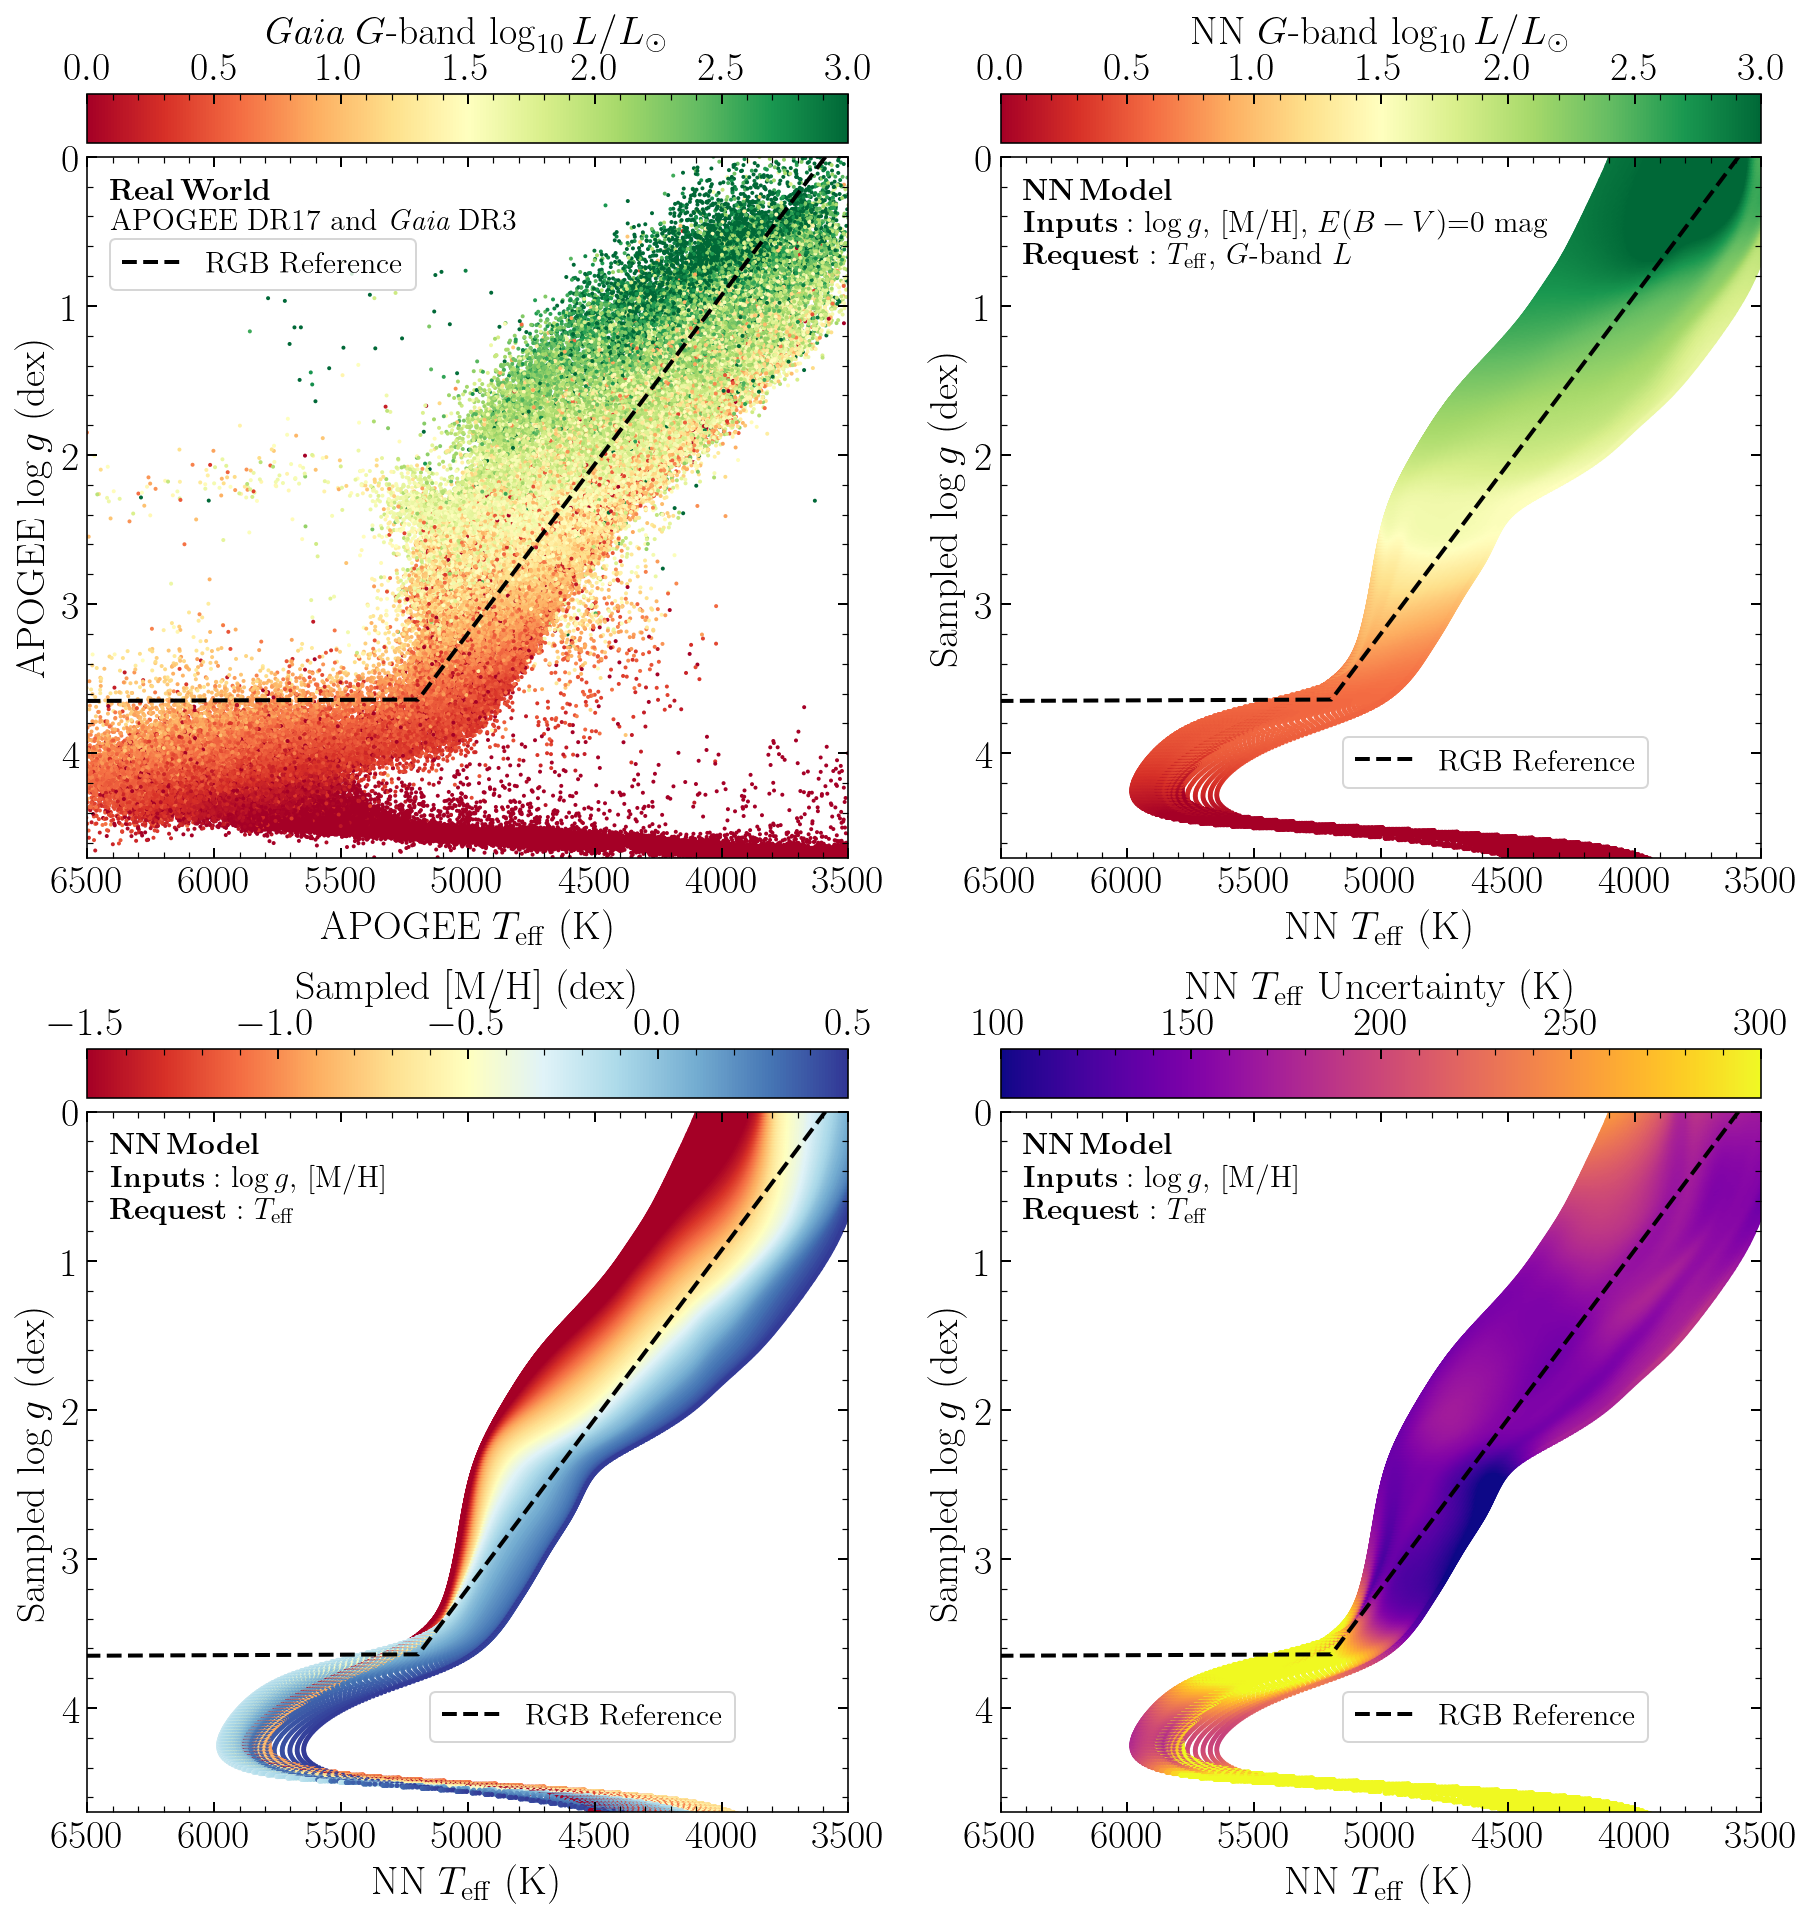

In [3]:
loggs = np.arange(0.0, 5.0, 0.01)
m_h = np.arange(-2, 0.5, 0.02)
teffs = np.array([estimate_teff_from_logg_rgb(l) for l in loggs])

ls = []
ms = []
for l in loggs:
    for m in m_h:
        ls.append(l)
        ms.append(m)
nn_model.perceive(np.column_stack([ls, ms, np.ones_like(ls)*-7.]), ["logg", "m_h", "logebv"])
result = nn_model.request(["g_fakemag"])
nn_logsol = fakemag_to_logsol(result["g_fakemag"], band="G")
nn_model.clear_perception()

nn_model.perceive(np.column_stack([ls, ms]), ["logg", "m_h"])
result = nn_model.request(["teff"])
nn_model.clear_perception()

ts, ts_error = result["teff"], result["teff_error"]
good_idx = (f_train["raw"]["g_fakemag"][()] > 0.)

fig = plt.figure(figsize=(15, 15.5))
subfigs = fig.subfigures(1, 1)
((ax1, ax2), (ax3, ax4)) = subfigs.subplots(2, 2, gridspec_kw={"hspace": 0.25})
mappable = ax1.scatter(
    f_train["raw"]["teff"][good_idx],
    f_train["raw"]["logg"][good_idx],
    c=fakemag_to_logsol(f_train["raw"]["g_fakemag"][good_idx], band="G"),
    s=1,
    vmin=0.,
    vmax=3.,
    cmap="RdYlGn",
    rasterized=True,
)
ax1.plot(teffs, loggs, c="k", lw=2, ls="--", label="RGB Reference")
ax1.set_xlim(6500.0, 3500.0)
ax1.set_ylim(4.7, 0.0)
ax1.set_xlabel("APOGEE $T_\mathrm{eff}$ (K)")
ax1.set_ylabel("APOGEE $\log{g}$ (dex)")
top_cbar(ax1, mappable, "$\\textit{Gaia}$ $G$-band $\log_{10} L / L_\odot$")
ax1.annotate(
    "$\\bf{Real\,World}$\nAPOGEE DR17 and $\\textit{Gaia}$ DR3",
    xy=(0.03, 0.97),
    xycoords=ax1,
    fontsize=15,
    ha="left",
    va="top",
    backgroundcolor="w",
)
ax1.legend(loc=(0.03, 0.81))

mappable = ax2.scatter(ts, ls, c=nn_logsol, s=2, vmin=0., vmax=3., cmap="RdYlGn", rasterized=True)
ax2.plot(teffs, loggs, c="k", lw=2, ls="--", label="RGB Reference")
ax2.set_xlim(6500.0, 3500.0)
ax2.set_ylim(4.7, 0.0)
ax2.set_xlabel("NN $T_\mathrm{eff}$ (K)")
ax2.set_ylabel("Sampled $\log{g}$ (dex)")
top_cbar(ax2, mappable, "NN $G$-band $\log_{10} L / L_\odot$")
ax2.annotate(
    "$\\bf{NN\,Model}$\n$\\bf{Inputs:}$ $\log{g}$, [M/H], $E(B-V)$=0 mag\n$\\bf{Request:}$ $T_{\mathrm{eff}}$, $G$-band $L$",
    xy=(0.03, 0.97),
    xycoords=ax2,
    fontsize=15,
    ha="left",
    va="top",
)
ax2.legend(loc=(0.45, 0.1))

mappable = ax3.scatter(ts, ls, c=ms, s=2, vmin=-1.5, vmax=0.5, cmap="RdYlBu", rasterized=True)
ax3.plot(teffs, loggs, c="k", lw=2, ls="--", label="RGB Reference")
ax3.set_xlim(6500.0, 3500.0)
ax3.set_ylim(4.7, 0.0)
ax3.set_xlabel("NN $T_\mathrm{eff}$ (K)")
ax3.set_ylabel("Sampled $\log{g}$ (dex)")
top_cbar(ax3, mappable, "Sampled [M/H] (dex)")
ax3.annotate(
    "$\\bf{NN\,Model}$\n$\\bf{Inputs:}$ $\log{g}$, [M/H]\n$\\bf{Request:}$ $T_{\mathrm{eff}}$",
    xy=(0.03, 0.97),
    xycoords=ax3,
    fontsize=15,
    ha="left",
    va="top",
)
ax3.legend(loc=(0.45, 0.1))

mappable = ax4.scatter(ts, ls, c=ts_error, s=2, vmin=100.0, vmax=300.0, cmap="plasma", rasterized=True)
ax4.plot(teffs, loggs, c="k", lw=2, ls="--", label="RGB Reference")
ax4.set_xlim(6500.0, 3500.0)
ax4.set_ylim(4.7, 0.0)
ax4.set_xlabel("NN $T_\mathrm{eff}$ (K)")
ax4.set_ylabel("Sampled $\log{g}$ (dex)")
top_cbar(ax4, mappable, "NN $T_\mathrm{eff}$ Uncertainty (K)")
ax4.annotate(
    "$\\bf{NN\,Model}$\n$\\bf{Inputs:}$ $\log{g}$, [M/H]\n$\\bf{Request:}$ $T_{\mathrm{eff}}$",
    xy=(0.03, 0.97),
    xycoords=ax4,
    fontsize=15,
    ha="left",
    va="top",
)
ax4.legend(loc=(0.45, 0.1))

fig.savefig("./figs/kiel_perception.pdf", bbox_inches="tight", dpi=200)

## Where the Model Pay Attention to?

There is actually no surprise that model can directly give you the information request when the information is given and have good prediction for different combinations of inputs.

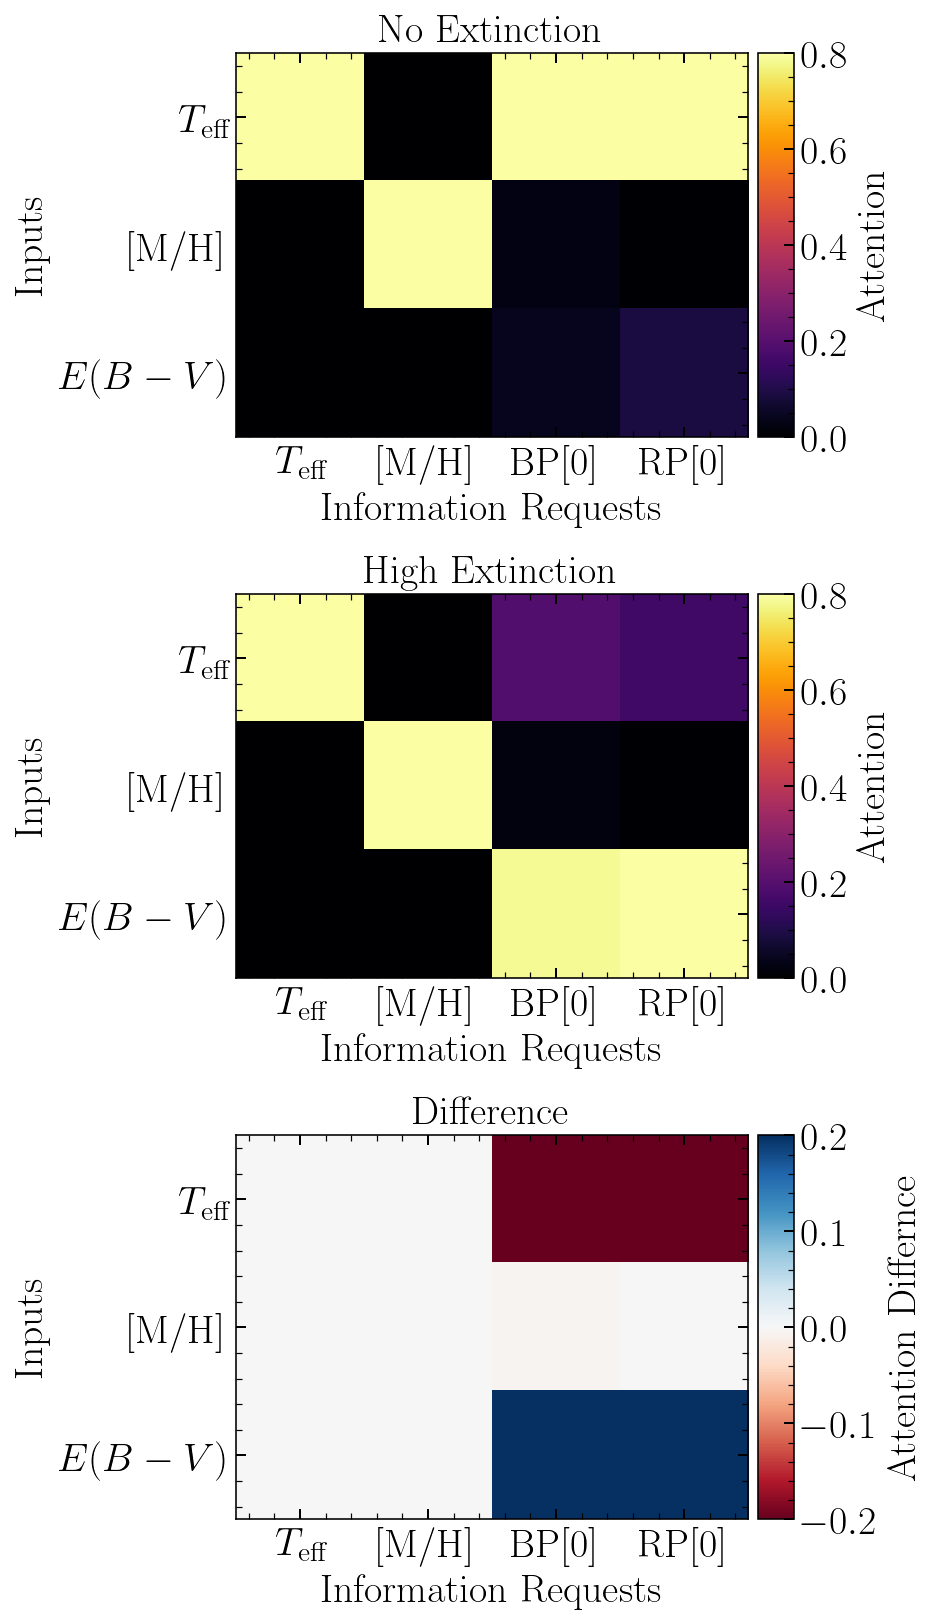

In [3]:
def plot_attention_map(attention_score, inputs_names, outputs_names, ax, cmap="inferno", vmin=0, vmax=None, lognorm=False):
    input_length = len(inputs_names)
    output_length = len(outputs_names)
    if lognorm:
        norm = matplotlib.colors.LogNorm()()
    else:
        norm = None
    mappable = ax.imshow(attention_score[:input_length], cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)
    ax.set_xlabel("Information Requests")
    ax.set_ylabel("Inputs")
    ax.set_xticks(np.arange(0, output_length))
    ax.set_xticklabels(outputs_names)
    ax.set_yticks(np.arange(0, input_length))
    ax.set_yticklabels(inputs_names)
    
    return mappable

nn_model.perceive([5000., 0.0, -7.], ["teff", "m_h", "logebv"])
_, attn_no_extinction = nn_model.request(
    ["teff", "m_h", "bp0", "rp0"], return_attention_scores=True
)
nn_model.clear_perception()
nn_model.perceive([5000., 0.0, -1.], ["teff", "m_h", "logebv"])
_, attn_high_extinction = nn_model.request(
    ["teff", "m_h", "bp0", "rp0"], return_attention_scores=True
)
nn_model.clear_perception()


fig = plt.figure(figsize=(5, 14))
subfigs = fig.subfigures(1, 1)
# ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8))
ax1, ax2, ax3 = subfigs.subplots(3, 1, gridspec_kw={"hspace": 0.15})

ax1.set_title("No Extinction")
ax2.set_title("High Extinction")
ax3.set_title("Difference")
mappable = plot_attention_map(
    attn_no_extinction[0],
    ["$T_\mathrm{eff}$", "[M/H]", "$E(B-V)$"],
    ["$T_\mathrm{eff}$", "[M/H]", "BP[0]", "RP[0]"],
    ax=ax1,
    vmax=0.8,
)
ax_divider = make_axes_locatable(ax1)
cax = ax_divider.append_axes("right", size="7%", pad=0.07)
plt.colorbar(mappable, cax=cax, label="Attention")

mappable = plot_attention_map(
    attn_high_extinction[0],
    ["$T_\mathrm{eff}$", "[M/H]", "$E(B-V)$"],
    ["$T_\mathrm{eff}$", "[M/H]", "BP[0]", "RP[0]"],
    ax=ax2,
    vmax=0.8,
)

ax_divider = make_axes_locatable(ax2)
cax = ax_divider.append_axes("right", size="7%", pad=0.07)
plt.colorbar(mappable, cax=cax, label="Attention")

mappable = plot_attention_map(
    attn_high_extinction[0] - attn_no_extinction[0],
    ["$T_\mathrm{eff}$", "[M/H]", "$E(B-V)$"],
    ["$T_\mathrm{eff}$", "[M/H]", "BP[0]", "RP[0]"],
    ax=ax3,
    cmap="RdBu",
    vmin=-0.2, 
    vmax=0.2,
)

ax_divider = make_axes_locatable(ax3)
cax = ax_divider.append_axes("right", size="7%", pad=0.07)
plt.colorbar(mappable, cax=cax, label="Attention Differnce")

fig.savefig("./figs/attention.pdf", bbox_inches="tight")
